## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Blog-Generator"

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

# model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm=ChatGroq(model="qwen-2.5-32b")

## Defining the tools

#### Arxiv

In [2]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

@traceable
def arxiv_search(query):
    """
        Search for the top 3 results according to the user query using ArxivAPIWrapper.
        The information returned is a list with the top 3 related articles with at least the following information:
        Title
        Published
        Authors
        Summary
        PDF_url
    """

    # Using qwen-2.5-32b limits to 6000 per minute so I set doc_content_chars_max = 5900
    arxiv = ArxivAPIWrapper(
        top_k_results = 3,
        ARXIV_MAX_QUERY_LENGTH = 300,
        load_all_available_meta = True,
        doc_content_chars_max = 5500
    )

    # Run Query and Get Results
    # query = "GAN's"
    results = arxiv.load(query)

    for article in results:
        print(f"Title: {article.metadata.get('Title', 'N/A')}")
        print(f"Published: {article.metadata.get('Published', 'N/A')}")
        print(f"Authors: {article.metadata.get('Authors', 'N/A')}\n")
        print(f"Summary: {article.metadata.get('Summary', 'N/A')[:250]}\n")
        print(f"PDF url: {article.metadata.get('entry_id', 'N/A')}\n")
    return results


#### Wikipedia

In [3]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

## Binding the tools

In [4]:
tools=[wiki,arxiv_search]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=True)

## Define the Initial State

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [6]:
# System message
sys_msg = SystemMessage(content=
                        """You are a helpful assistant tasked with creating a blog.
                        Your first commitment is:
                        1. Use the arxiv tool to search for the top 3 articles related to the user's question.

                        2. Give the user the option to use wikipedia in case they want to research a term in the summaries.

                        3. Wait for user's feedback

                        4. If rejected try again from point 1.

                        5. If accepted create a blog with the articles information.
                     
                        """)                      


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Defining the graph

#### First I define a node that will be helpful for the human feedback

In [7]:
# from langgraph.graph import START, StateGraph, END
# def human_feedback(state: MessagesState):
#     """ Return the next node to execute """

#     # Check if human feedback
#     # human_analyst_feedback=state.get('human_analyst_feedback', None)
#     # if human_analyst_feedback:
#     return "tools"
    
#     # Otherwise end
#     return END

In [8]:
from langgraph.graph import START, StateGraph, END

@traceable
def human_feedback(state: MessagesState):
    """ Return the next node to execute """
    user_input = state["messages"][-1].content
    if "yes" in user_input.lower():
        return "tools"
    return END

#### Then I define the graph

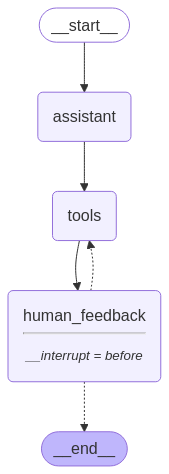

In [9]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("human_feedback",human_feedback)
builder.add_node("tools",ToolNode(tools))
# Define edges
builder.add_edge(START,"assistant")
builder.add_edge("assistant","tools")
builder.add_edge("tools","human_feedback")
builder.add_conditional_edges(
    "human_feedback",tools_condition,["tools",END]
)
# builder.add_edge( "tools","human_feedback")

#workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})

# Set up memory
memory = MemorySaver()
# Compile the graph with memory
scienceBlogCreator = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

# Show
display(Image(scienceBlogCreator.get_graph().draw_mermaid_png()))

## Using the Agent

#### First call to use the Arxiv tool

#### Invoking the llm

In [10]:
# Input
# user_input=input("What do you want to research about?")
user_input="GANs"
messages = {"messages": HumanMessage(content=user_input)}

thread={"configurable":{"thread_id":"arxiv_call_1"}}
# messages = scienceBlogCreator.invoke({"messages":messages})
# messages={'messages':HumanMessage(content=messages)}
# scienceBlogCreator.stream(messages,thread,stream_mode="values")
for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_bk6x)
 Call ID: call_bk6x
  Args:
    query: GANs
Title: Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey
Published: 2021-11-26
Authors: Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley

Summary: This is a tutorial and survey paper on Generative Adversarial Network (GAN),
adversarial autoencoders, and their variants. We start with explaining
adversarial learning and the vanilla GAN. Then, we explain the conditional GAN
and DCGAN. The mode col

PDF url: http://arxiv.org/abs/2111.13282v1

Title: GAN You Do the GAN GAN?
Published: 2019-04-01
Authors: Joseph Suarez

Summary: Generative Adversarial Networks (GANs) have become a dominant class of
generative models. In recent years, GAN variants have yielded especially
impressive results in the synthesis

In [11]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_bk6x)
 Call ID: call_bk6x
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWasserstein GAN, are introduced for resolving t

In [12]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [13]:
scienceBlogCreator.get_state(thread).tasks

(PregelTask(id='f898353c-9e4f-9c58-84fb-1534444a5cde', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),)

## Human Feedback

#### Update the state asking to the user if they want to research a topic in wikipedia

In [14]:
# user_input=input("Do you want to clarify any term by using Wikipedia?")
user_input="yes, research what is a networks"
scienceBlogCreator.update_state(
    thread,
    {"messages":[
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should go to END."""),
        HumanMessage(content=user_input)
        ]},
    #  as_node="human_feedback"
)

{'configurable': {'thread_id': 'arxiv_call_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efff63a-369b-676f-8003-38cb4bd52bb6'}}

In [15]:
# Input
# user_input=input("What do you want to research about?")
user_input="GANs"
messages = {"messages": HumanMessage(content=user_input)}

thread={"configurable":{"thread_id":"arxiv_call_1"}}
# messages = scienceBlogCreator.invoke({"messages":messages})
# messages={'messages':HumanMessage(content=messages)}
# scienceBlogCreator.stream(messages,thread,stream_mode="values")
for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_2c1q)
 Call ID: call_2c1q
  Args:
    query: Neural Networks
================================= Tool Message =================================
Name: wikipedia

Page: Neural network (machine learning)
Summary: In machine learning, a neural network (also artificial neural network or neural net, abbreviated ANN or NN) is a model inspired by the structure and function of biological neural networks in animal bra


In [16]:
for event in scienceBlogCreator.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: wikipedia

Page: Neural network (machine learning)
Summary: In machine learning, a neural network (also artificial neural network or neural net, abbreviated ANN or NN) is a model inspired by the structure and function of biological neural networks in animal bra


InvalidUpdateError: Expected dict, got __end__
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [ ]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [ ]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_gswp)
 Call ID: call_gswp
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWasserstein GAN, are introduced for resolving t

In [ ]:
# Continue the graph execution
for event in scienceBlogCreator.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

yes, research adversarial networks


InvalidUpdateError: Expected dict, got tools
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [ ]:
state_after_feedback = scienceBlogCreator.get_state(thread).values
decision = tools_condition(state_after_feedback)
print(f"🛠️ tools_condition decision: {decision}")


🛠️ tools_condition decision: __end__
